# From [Jake Vanderplas' Tutorial](https://www.youtube.com/watch?v=rN7g4gzO2sk)

## Icing Model

Evolve the spin/energy of a matrix over time. For every point in the matrix, if the sum of the neighboring points is large, then you can shift the energy of the point in question towards that sum, plus some stochasticity.

In [14]:
import numpy as np
from PIL import Image

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

def display_spin_field(field):
    return Image.fromarray(np.uint8((field+1)*0.5*255))

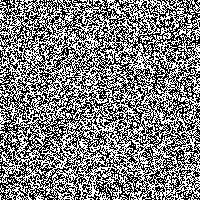

In [15]:
display_spin_field(random_spin_field(200, 200))

In [30]:
# beta is inverse temperature parameter
def ising_step(field, beta=0.4):
    N, M = field.shape
    for n in range(N):
        for m in range(M):
            _ising_update(field, n, m, beta)
    return field

def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            #exclude point in question
            if i==n and j ==m:
                continue
            total += field[i%N, j%M]

    # if energy is greater, or stochastic prob, switch spin state
    dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n,m] *= -1
    elif np.exp(-dE * beta) >  np.random.rand():
        field[n,m] *= -1
        

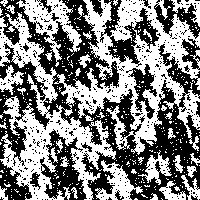

In [31]:
display_spin_field(ising_step(random_spin_field(200, 200)))

In [37]:
from ipywidgets import interact

def display_img_seq(images):
    def _show(frame=(0, len(images) -1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [40]:
images = [random_spin_field(200, 200)]
for i in range(100):
    images.append(ising_step(images[-1].copy()))
display_img_seq(images)

interactive(children=(IntSlider(value=50, description='frame'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_img_seq.<locals>._show>

In [41]:
% load_ext Cython

In [64]:
%%cython -a
import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX
    
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_step(int[:, :]field, float beta=0.4):
    # beta is inverse temperature parameter
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int m, n
    for n in range(N):
        for m in range(M):
            _cy_ising_update(field, n, m, beta)
    return np.array(field)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cy_ising_update(int [:, :]field, int n, int m, float beta):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int i, j
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            #exclude point in question
            if i==n and j ==m:
                continue
            total += field[i%N, j%M]

    # if energy is greater, or stochastic prob, switch spin state
    cdef float dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n,m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n,m] *= -1
        

In [65]:
field = random_spin_field(200, 200)
%timeit ising_step(field)
%timeit cy_ising_step(field)

811 ms ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.37 ms ± 684 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
images = [random_spin_field(500, 500)]
for i in range(25):
    images.append(cy_ising_step(images[-1].copy()))
display_img_seq(images)

interactive(children=(IntSlider(value=12, description='frame', max=25), Output()), _dom_classes=('widget-inter…

<function __main__.display_img_seq.<locals>._show>